In [203]:
import numpy as np
import scipy.optimize as opt
import copy
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm

from scipy.sparse import spdiags
from scipy.sparse import eye
from scipy.interpolate import RectBivariateSpline

import time

from numba import jit

# Parameters

In [204]:
rho = 0.05 # discount rate
r = 0.05 # return on assets
delta = 0.05 # depreciaton of human capital
c_param = 2 # CRRA utility parameter on consumption
l_param = 2 # ditto for leisure
B_param = 2 # ditto for bequest at end-of-life t=T

params = [rho, r, delta, c_param, l_param]

# Time parameters
T = 70 # length of lifespan
nT = 70 # number of time grids
dt = T/nT # Length of each time grid

# State space parameters
na = 50 # number of asset grid points
nk = 50 # number of human capital grid points

amin = 0
amax = 700

kmin = 1
kmax = 800

# Utility functions and labor market tradeoff functions

In [205]:
# Define utility functions
@jit
def u(c, c_param):
    return (c**(1-c_param))/(1-c_param)

@jit
def u_prime(c, c_param):
    return c**(-c_param)

@jit
def u_prime_inverse(x, c_param):
    return x**(-1/c_param)

@jit
def uh(h, l_param):
    return ((1-h)**(1-l_param))/(1-l_param)

@jit
def uh_prime(h, l_param):
    return -(1-h)**(-l_param)

@jit
def uh_prime_inverse(x, l_param):
    return 1 - ((-x)**(-1/l_param))

In [206]:
# Labor market functions
@jit
def g(x):
    return 1.25 - (x*(1.25**0.5 - 0.5) + 0.5)**2

@jit
def g_prime(x):
    return -2*(x*(1.25**0.5 - 0.5) + 0.5)*(1.25**0.5 - 0.5)

@jit
def g_prime_inverse(x):
    return (x/(-2*(1.25**0.5 - 0.5)) - 0.5)/(1.25**0.5 - 0.5)

# Create grids

In [207]:
# State grids
a_vect = amin + np.linspace(0, 1, na)*(amax - amin) # Vector of A
da = (amax - amin)/(na - 1) # delta in A
aa = np.repeat(a_vect[:, None], nk, axis = 1) # Grid of A

k_vect = kmin + np.linspace(0, 1, nk)*(kmax - kmin) # Vector of A
dk = (kmax - kmin)/(nk - 1) # delta in K
kk = np.repeat(k_vect[None, :], na, axis = 0) # Grid of K

# Preallocate fwd/bwd derivatives, policy grid, value function grid
dVaF = np.zeros((na, nk))
dVaB = np.zeros((na, nk))
dVkF = np.zeros((na, nk))
dVkB = np.zeros((na, nk))

V_t = np.zeros((na, nk, nT+1))
C_t = np.zeros((na, nk, nT))
H_t = np.zeros((na, nk, nT))
X_t = np.zeros((na, nk, nT))
U_t = np.zeros((na, nk, nT))
mu_a_t = np.zeros((na, nk, nT))
mu_k_t = np.zeros((na, nk, nT))
dVa_t = np.zeros((na, nk, nT))
dVk_t = np.zeros((na, nk, nT))


# Arrays to store intermediate results for debugging
dVaF_t = np.zeros((na, nk, nT))
dVaB_t = np.zeros((na, nk, nT))
dVkF_t = np.zeros((na, nk, nT))
dVkB_t = np.zeros((na, nk, nT))
dVaS_t = np.zeros((na, nk, nT))
dVkS_t = np.zeros((na, nk, nT))
I_valid_t = np.zeros((na, nk, nT))
I_type_t = np.zeros((na, nk, nT))
I_unique_t = np.zeros((na, nk, nT))
I_stacked_t = np.zeros((na, nk, 5, nT))


# Terminal value
small_number1 = 1
small_number2 = 1
v_terminal = small_number1*((small_number2 + aa)**(1-B_param))/(1-B_param)

# Place terminal value into value function grid
V_t[:, :, nT] = v_terminal

# Boundary condition finder functions

In [208]:
# Drift functions for both a and k variables. Called by boundary_dVa and boundary_dVk functions
@jit
def drift_a(dVa, dVk, a, k, params):
    rho, r, delta, c_param, l_param = params
    c = u_prime_inverse(dVa, c_param)
    x = np.clip(g_prime_inverse(-dVk/dVa), 0, 1)
    h = np.clip(uh_prime_inverse(-dVa*g(x)*k - dVk*x*k, l_param), 0, 1)

    mu_a = r*a + g(x)*h*k - c
    return mu_a

@jit
def drift_k(dVk, dVa, a, k, params):
    rho, r, delta, c_param, l_param = params
    x = np.clip(g_prime_inverse(-dVk/dVa), 0, 1)
    h = np.clip(uh_prime_inverse(-dVa*g(x)*k - dVk*x*k, l_param), 0, 1)

    mu_k = x*h*k - delta*k
    return mu_k

In [209]:
# This function finds dVa that leads to mu_a = 0 given dVk
@jit
def boundary_dVa(dVk, a, k, params):
    
    # Find dVa that leads to negative drift in a
    dVa_neg = 1
    while True:
        if drift_a(dVa_neg, dVk, a, k, params) < 0:
            break
        else:
            dVa_neg /= 2

    # Find dVa that leads to positive drift in a
    dVa_pos = 1
    while True:
        if drift_a(dVa_pos, dVk, a, k, params) > 0:
            break
        else:
            dVa_pos *= 2

    # Use brentq to find the value of dVa where drift in a is 0, should be in between
    sol = opt.brentq(drift_a, dVa_neg, dVa_pos, args = (dVk, a, k, params), xtol = 1e-16, rtol = 1e-15)
    return sol

# This function finds dVk that leads to mu_k = 0 given dVa
@jit
def boundary_dVk(dVa, a, k, params):
    
    # Find dVk that leads to negative drift in k
    dVk_neg = 1
    while True:
        if drift_k(dVk_neg, dVa, a, k, params) < 0:
            break
        else:
            dVk_neg /= 2

    # Find dVk that leads to positive drift in k
    dVk_pos = 1
    while True:
        if drift_k(dVk_pos, dVa, a, k, params) > 0:
            break
        else:
            dVk_pos *= 2

    sol = opt.brentq(drift_k, dVk_neg, dVk_pos, args = (dVa, a, k, params), xtol = 1e-16, rtol = 1e-15)
    return sol

# Find steady-state

In [210]:
# Define a function that computes mu_k for a given dVk where dVa is set to be such that mu_a=0
@jit
def drift_k_dVk(dVk, a, k, params):
    rho, r, delta, c_param, l_param = params

    # dVa that leads to mu_a = 0 for given dVk
    dVa = boundary_dVa(dVk, a, k, params)

    mu_k = drift_k(dVk, dVa, a, k, params)
    
    return mu_k

In [211]:
# Define a function that finds dVk that leads to mu_k=0 where dVa is set to be such that mu_a=0
@jit
def ss_dVk(a, k, params):
    rho, r, delta, c_param, l_param = params

    # Find dVk that leads to negative drift in k
    dVk_neg = 1
    while True:
        if drift_k_dVk(dVk_neg, a, k, params) < 0:
            break
        else:
            dVk_neg = dVk_neg/2

    # Find dVk that leads to positive drift in k
    dVk_pos = 1
    while True:
        if drift_k_dVk(dVk_pos, a, k, params) > 0:
            break
        else:
            dVk_pos = dVk_pos + 1

    sol = opt.brentq(drift_k_dVk, dVk_neg, dVk_pos, args = (a, k, params), xtol = 1e-16, rtol = 1e-15)

    return sol

In [212]:
# Define a function that computes controls and drifts for given dV and state
@jit
def control_drift(dVa, dVk, a, k, params):
    rho, r, delta, c_param, l_param = params

    c = u_prime_inverse(dVa, c_param)
    x = np.clip(g_prime_inverse(-dVk/dVa), 0, 1)
    h = np.clip(uh_prime_inverse(-dVa*g(x)*k - dVk*x*k, l_param), 0, 1)

    mu_a = r*a + g(x)*h*k - c
    mu_k = x*h*k - delta*k

    return c, h, x, mu_a, mu_k

In [213]:
# Find steady-state dVk0
dVk0 = np.zeros((na, nk))
dVa0 = np.zeros((na, nk))

for i in range(na):
    for j in range(nk):
        dVk0[i,j] = ss_dVk(aa[i,j], kk[i,j], params)
        dVa0[i,j] = boundary_dVa(dVk0[i,j], aa[i,j], kk[i,j], params)

In [214]:
# Fill in the rest of the steady-state values
C0, H0, X0, mu_a0, mu_k0 = control_drift(dVa0, dVk0, aa, kk, params)

In [215]:
# Wrap a boundary steady-state checker within a function
@jit
def k_steadystate(dVa, a, k, params):
    # Find dVk that leads to mu_k = 0
    dVk = boundary_dVk(dVa, a, k, params)

    # Policy and drift
    c, h, x, mu_a, mu_k = control_drift(dVa, dVk, a, k, params)

    return(dVk, mu_a, mu_k)

# Wrap k boundary steady-state checker within a function
@jit
def a_steadystate(dVk, a, k, params):
    # Find dVa that leads to mu_a = 0
    dVa = boundary_dVa(dVk, a, k, params)

    # Policy and drift
    c, h, x, mu_a, mu_k = control_drift(dVa, dVk, a, k, params)

    return(dVa, mu_a, mu_k)

# Finite difference upwind scheme finder function

In [216]:
def finite_difference_upwind_scheme(V, na, nk, da, dk):
    
    dVaF = np.zeros((na, nk))
    dVaB = np.zeros((na, nk))
    dVkF = np.zeros((na, nk))
    dVkB = np.zeros((na, nk))
    dVaS = np.zeros((na, nk))
    dVkS = np.zeros((na, nk))

    # Construct forward and backward differences for a and k
    dVaF[0:na-1, :] = (V[1:na, :] - V[0:na-1, :])/da
    dVaF[na-1, :] = dVaF[na-2, :]

    dVkF[:, 0:nk-1] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
    dVkF[:, nk-1] = dVkF[:, nk-2]

    dVaB[1:na, :] = (V[1:na, :] - V[0:na-1, :])/da
    dVaB[0, :] = dVaB[1, :]

    dVkB[:, 1:nk] = (V[:, 1:nk] - V[:, 0:nk-1])/dk
    dVkB[:, 0] = dVkB[:, 1]

    # Verify value function is increasing in a
    if np.sum(dVaF < 0) > 0 or (np.sum(dVaB < 0) > 0): # Print message if there exists an element of dVa < 0
        print('V is not monotonically increasing in a')

    if (np.sum(dVkF < 0) > 0) or (np.sum(dVkB < 0) > 0): # Print message if there exists an element of dVk < 0
        print('V is not monotonically increasing in k')

    # Compute policies and drift
    cFF, hFF, xFF, mu_aFF, mu_kFF = control_drift(dVaF, dVkF, aa, kk, params)
    cFB, hFB, xFB, mu_aFB, mu_kFB = control_drift(dVaF, dVkB, aa, kk, params)
    cBF, hBF, xBF, mu_aBF, mu_kBF = control_drift(dVaB, dVkF, aa, kk, params)
    cBB, hBB, xBB, mu_aBB, mu_kBB = control_drift(dVaB, dVkB, aa, kk, params)

    # Create indicator matrices indicating consistency of direction of drift with fwd/bwd difference for both state variables
    # Impose False at boundary if fwd/bwd difference implies drift sends state beyond boundary
    # Note that inconsistency may arise due to presence of steady-state in a or k or both dimensions. At the boundaries, these have to be checked for first before setting up reflecting boundaries, i.e., a may be already be decreasing at a_max but may show up as inconsistent if k is at steady-state, so setting up a reflecting boundary causes a to stay put instead of decreasing
    I_FF = np.logical_and(mu_aFF > 0, mu_kFF > 0)
    I_FF[na-1, :] = False
    I_FF[:, nk-1] = False

    I_FB = np.logical_and(mu_aFB > 0, mu_kFB < 0)
    I_FB[na-1, :] = False
    I_FB[:, 0] = False

    I_BF = np.logical_and(mu_aBF < 0, mu_kBF > 0)
    I_BF[0, :] = False
    I_BF[:, nk-1] = False

    I_BB = np.logical_and(mu_aBB < 0, mu_kBB < 0)
    I_BB[0, :] = False
    I_BB[:, 0] = False

    # Steady-state indicator
    I_SS = np.zeros((na, nk), dtype=bool)

    # Compute validity of fwd/bwd difference combinations
    # Stack all indicator matrices
    I_stacked = np.zeros((na, nk, 5))
    I_stacked[:, :, 0] = I_SS
    I_stacked[:, :, 1] = I_FF
    I_stacked[:, :, 2] = I_FB
    I_stacked[:, :, 3] = I_BF
    I_stacked[:, :, 4] = I_BB

    # Use logical-or over all 4 combinations; if at least one is valid, I_valid is True
    I_valid = np.logical_or.reduce((I_SS, I_FF, I_FB, I_BF, I_BB))

    # Check for uniqueness of valid combinations; some are not unique due to non-convexity of value function
    I_unique = np.sum(I_stacked, axis = 2) <= 1

    # Now perform tie-breaking by choosing combination that has largest Hamiltonian among valid combinations
    # Forward and backwards Hamiltonians
    H_FF = u(cFF, c_param) + uh(hFF, l_param) + mu_aFF*dVaF + mu_kFF*dVkF
    H_FB = u(cFB, c_param) + uh(hFB, l_param) + mu_aFB*dVaF + mu_kFB*dVkB
    H_BF = u(cBF, c_param) + uh(hBF, l_param) + mu_aBF*dVaB + mu_kBF*dVkF
    H_BB = u(cBB, c_param) + uh(hBB, l_param) + mu_aBB*dVaB + mu_kBB*dVkB
    H_stacked = np.zeros((na, nk, 5))
    H_stacked[:, :, 0] = -np.Inf
    H_stacked[:, :, 1] = H_FF
    H_stacked[:, :, 2] = H_FB
    H_stacked[:, :, 3] = H_BF
    H_stacked[:, :, 4] = H_BB

    # Take values of Hamiltonians if combination is valid; -inf otherwise
    H_valid = np.where(I_stacked, H_stacked, -np.Inf)

    # This selects the combination with the largest Hamiltonian among all valid combinations
    I_type = np.argmax(H_valid, axis = 2)

    # Check for either steady-state or need for reflecting boundaries at boundary of state grid
    # Steady-state k at a_min
    i = 0
    for j in range(1, nk-1):
        if (I_valid[i, j] == False) and (mu_aFF[i, j] > 0) and (mu_aFB[i, j] > 0):
            #print('k is steady-state')

            aij = aa[i, j]
            kij = kk[i, j]

            # Find dVk such that mu_k = 0 by using k-ss finder function
            dVaij = dVaF[i, j]
            dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

            # If FS is consistent:
            if (mu_aij > 0):
                dVkS[i, j] = dVkij
                I_valid[i, j] = True
                I_type[i, j] = 7

    # Steady-state k at a_max
    i = na-1
    for j in range(1, nk-1):
        if (I_valid[i, j] == False) and (mu_aBF[i, j] < 0) and (mu_aBB[i, j] < 0):
            #print('k is steady-state')

            aij = aa[i, j]
            kij = kk[i, j]

            # Find dVk such that mu_k = 0 by using k-ss finder function
            dVaij = dVaB[i, j]
            dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

            # If BS is consistent:
            if (mu_aij < 0):
                dVkS[i, j] = dVkij
                I_valid[i, j] = True
                I_type[i, j] = 8

    # Steady-state a at k_min
    j = 0
    for i in range(1, na-1):
        if (I_valid[i, j] == False) and (mu_kFF[i, j] > 0) and (mu_kBF[i, j] > 0):
            #print('a is steady-state')

            aij = aa[i, j]
            kij = kk[i, j]

            # Find dVa such that mu_a = 0 by using a-ss finder function
            dVkij = dVkF[i, j]
            dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

            # If SF is consistent:
            if (mu_kij > 0):
                dVaS[i, j] = dVaij
                I_valid[i, j] = True
                I_type[i, j] = 5

    # Steady-state a at k_max
    j = nk-1
    for i in range(1, na-1):
        if (I_valid[i, j] == False) and (mu_kFB[i, j] < 0) and (mu_kBB[i, j] < 0):
            #print('a is steady-state')

            aij = aa[i, j]
            kij = kk[i, j]

            # Find dVa such that mu_a = 0 by using a-ss finder function
            dVkij = dVkB[i, j]
            dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

            # If SB is consistent:
            if (mu_kij < 0):
                dVaS[i, j] = dVaij
                I_valid[i, j] = True
                I_type[i, j] = 6
    
    # Set up reflecting boundary condition at a_min
    # Loop over a_min (upper edge) in the j dimension
    i = 0
    for j in range(nk):
        if I_valid[i, j] == False:
            aij = aa[i, j]
            kij = kk[i, j]

            # Try SF scheme, so use dVkF
            dVkij = dVkF[i, j]

            # Find dVa such that mu_a = 0 using a-ss finder function
            dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

            # Check consistency of upwind scheme
            if (mu_kij >= 0) and (j != nk-1):
                # fwd diff for k is successful; SF scheme works
                I_valid[i, j] = True
                I_type[i, j] = 5

                # Boundary dVaS
                dVaS[i, j] = dVaij
                
            # SF scheme failed; try SB scheme
            else:
                dVkij = dVkB[i, j]
                dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

                if (mu_kij <= 0) and (j != 0):
                    # bwd diff for k is successful; SB scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 6

                    # Boundary dVaS
                    dVaS[i, j] = dVaij

    # Set up reflecting boundary condition at a_max
    # Loop over a_max (lower edge) in the j dimension
    i = na-1
    for j in range(nk):
        if I_valid[i, j] == False:
            if (j > 0) and (j < nk-1):
                print("a_max too small")
            
            aij = aa[i, j]
            kij = kk[i, j]

            # Try SF scheme, so use dVkF
            dVkij = dVkF[i, j]

            # Find dVa such that mu_a = 0 using a-ss finder function
            dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

            if (mu_kij >= 0) and (j != nk-1):
                # fwd diff for k is successful; SF scheme works
                I_valid[i, j] = True
                I_type[i, j] = 5

                # Boundary condition dVaS
                dVaS[i, j] = dVaij

            # SF scheme failed; try SB scheme
            else:
                dVkij = dVkB[i, j]
                dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

                if (mu_kij <= 0) and (j != 0):
                    # bwd diff for k is successful; BB scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 6

                    # Boundary dVaS
                    dVaS[i, j] = dVaij

    # Set up reflecting boundary condition at k_min
    # Loop over k_min (left edge) in the i dimension
    j = 0
    for i in range(na):
        if I_valid[i, j] == False:
            aij = aa[i, j]
            kij = kk[i, j]

            # Try FS scheme, so use dVaF
            dVaij = dVaF[i, j]

            # Find dVk such that mu_k = 0 using k-ss finder function
            dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

            if (mu_aij >= 0) and (i != na):
                # fwd diff for a is successful; FS scheme works
                I_valid[i, j] = True
                I_type[i, j] = 7

                # Boundary condition dVkS
                dVkS[i, j] = dVkij

            # FS scheme failed, try BS
            else:
                dVaij = dVaB[i, j]
                dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

                if (mu_aij <= 0) and (i != 0):
                    # bwd diff for a is successful; BS scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 8

                    # Boundary condition dVkS
                    dVkS[i, j] = dVkij

    # Set up reflecting boundary condition at k_max
    # Loop over k_max (upper edge) in the i dimension
    j = nk-1
    for i in range(na):
        if I_valid[i, j] == False:
            if (i > 0) and (i < na-1):
                print("k_max too small")
            
            aij = aa[i, j]
            kij = kk[i, j]

            # Try FS scheme, so use dVaF
            dVaij = dVaF[i, j]

            # Find dVk such that mu_k = 0 using k-ss finder function
            dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

            if (mu_aij >= 0) and (i != na):
                # fwd diff for a is successful; FS scheme works
                I_valid[i, j] = True
                I_type[i, j] = 7

                # Boundary condition dVkS
                dVkS[i, j] = dVkij

            # FS scheme failed, try BS
            else:
                dVaij = dVaB[i, j]
                dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

                if (mu_aij <= 0) and (i != 0):
                    # bwd diff for a is successful; BF scheme works
                    I_valid[i, j] = True
                    I_type[i, j] = 8

                    # Boundary condition dVkS
                    dVkS[i, j] = dVkij

    # Look for a or k steady-states in the interior
    # Check for consistent direction of drift for one of the state variables
    aF_consistent = np.logical_and((mu_aFF > 0), (mu_aFB > 0))
    aB_consistent = np.logical_and((mu_aBF < 0), (mu_aBB < 0))
    kF_consistent = np.logical_and((mu_kFF > 0), (mu_kBF > 0))
    kB_consistent = np.logical_and((mu_kFB < 0), (mu_kBB < 0))

    a_consistent = np.logical_or(aF_consistent, aB_consistent)
    k_consistent = np.logical_or(kF_consistent, kB_consistent)
    
    # Loop over grid points in the interior
    for i in range(1, na-1):
        for j in range(1, nk-1):
            if I_valid[i, j] == False:

                # k is steady-state
                if (a_consistent[i, j] == True) and (k_consistent[i, j] == False):
                    #print('k is steady-state')

                    aij = aa[i, j]
                    kij = kk[i, j]

                    # Find dVk such that mu_k = 0 using k-ss finder function
                    dVaij = dVaF[i, j]
                    dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

                    # If FS is consistent:
                    if mu_aij > 0:
                        dVkS[i, j] = dVkij
                        I_valid[i, j] = True
                        I_type[i, j] = 7

                    # FS scheme failed; try BS scheme
                    else:
                        dVaij = dVaB[i, j]
                        dVkij, mu_aij, mu_kij = k_steadystate(dVaij, aij, kij, params)

                        # If BS is consistent:
                        if mu_aij < 0:
                            dVkS[i, j] = dVkij
                            I_valid[i, j] = True
                            I_type[i, j] = 8


                if (a_consistent[i, j] == False) and (k_consistent[i, j] == True):
                    #print('a is steady-state')

                    aij = aa[i, j]
                    kij = kk[i, j]

                    # Find dVa such that mu_a = 0 using a-ss finder function
                    # First try SF scheme
                    dVkij = dVkF[i, j]
                    dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

                    # If SF is consistent:
                    if mu_kij > 0:
                        dVaS[i, j] = dVaij

                        I_valid[i, j] = True
                        I_type[i, j] = 5

                    # SF scheme failed; try SB scheme
                    else:
                        dVkij = dVkB[i, j]
                        dVaij, mu_aij, mu_kij = a_steadystate(dVkij, aij, kij, params)

                        # If BS is consistent:
                        if mu_kij < 0:
                            dVaS[i, j] = dVaij

                            I_valid[i, j] = True
                            I_type[i, j] = 6

    n_ss = np.sum(I_valid == False)

    return dVaF, dVaB, dVaS, dVkF, dVkB, dVkS, I_valid, I_type, I_stacked, I_unique, n_ss

# Iterate back from terminal value function

In [217]:
start_time = time.process_time()

In [218]:
for t in range(nT-1, -1, -1):
    age = t*dt
    print(f'Age is {age}, t is {t}.')
    V = V_t[:, :, t+1]

    # Call finite difference upwind scheme finder function
    dVaF, dVaB, dVaS, dVkF, dVkB, dVkS, I_valid, I_type, I_stacked, I_unique, n_ss = finite_difference_upwind_scheme(V, na, nk, da, dk)
    print(f"{n_ss} ss grid points")

    # Construct dVa and dVk matrices
    # If no scheme is valid, use steady-state values, i.e. stay put
    # Note: SS is I_type == 0, FF == 1, FB == 2, BF == 3, BB == 4, SF == 5, SB == 6, FS == 7, BS == 8 
    dVa = (dVaF*(I_type == 1) + dVaF*(I_type == 2) + dVaB*(I_type == 3) + dVaB*(I_type == 4) + dVaS*(I_type == 5) + dVaS*(I_type == 6) + dVaF*(I_type == 7) + dVaB*(I_type == 8))*I_valid + dVa0*(~I_valid)
    dVk = (dVkF*(I_type == 1) + dVkB*(I_type == 2) + dVkF*(I_type == 3) + dVkB*(I_type == 4) + dVkF*(I_type == 5) + dVkB*(I_type == 6) + dVkS*(I_type == 7) + dVkS*(I_type == 8))*I_valid + dVk0*(~I_valid)

    # Compute policies
    C, H, X, mu_a, mu_k = control_drift(dVa, dVk, aa, kk, params)

    # Check that a_max and k_max are sufficiently large
    

    U = u(C, c_param) + uh(H, l_param)

    # Construct sparse diagonal matrix A
    # Reshape mu_a using column-major (Fortran) order
    mu_a_diag = np.reshape(mu_a, na*nk, order='F')/da

    # -1 diagonal is mu_a<0, +1 diag is mu>0
    # Shift elements forward 1 index as placement in upper diagonal in spdiags lops off the first element. Want diagonal to start with the 1st element.
    mu_a_diag_pos = np.roll(np.clip(mu_a_diag, 0, None), 1)

    # Shift elements back 1 index as placement in lower diagonal in spdiags lops off the last element. Want diagonal to start with the 2nd element.
    mu_a_diag_neg = np.roll(-np.clip(mu_a_diag, None, 0), -1) 

    # Reshape mu_k using column-major (Fortran) order
    mu_k_diag = np.reshape(mu_k, na*nk, order='F')/dk

    # -na diag is mu_k < 0, +na diag is mu_k > 0
    # Shift elements forward na index as placement in upper diagonal in spdiags lops off the first na elements. Want diagonal to start with 1st element.
    mu_k_diag_pos = np.roll(np.clip(mu_k_diag, 0, None), na)

    # Shift elements back na index as placement in lower diagonal in spdiags lops off the last na elements. Want diagonal to start with the na'th element
    mu_k_diag_neg = np.roll(-np.clip(mu_k_diag, None, 0), -na)

    # Construct main diagonal
    main_diag = np.reshape(-np.abs(mu_a)/da - np.abs(mu_k)/dk, na*nk, order='F')

    A = spdiags(np.array([mu_k_diag_neg, mu_a_diag_neg, main_diag, mu_a_diag_pos, mu_k_diag_pos]), np.array([-na, -1, 0, 1, na]), na*nk, na*nk)

    # Solve set of linear equations to obtain V for current period from V of next period
    b = np.reshape(U + V/dt, na*nk, order='F')
    B = (1/dt + rho)*np.identity(na*nk) - A
    V_stacked = np.linalg.solve(B, b)

    V_t[:, :, t] = copy.copy(np.reshape(V_stacked, (na, nk), order = 'F'))

    # Store results for debugging
    C_t[:, :, t] = copy.copy(C)
    H_t[:, :, t] = copy.copy(H)
    X = np.where(H == 0, 0, X)
    X_t[:, :, t] = copy.copy(X)
    U_t[:, :, t] = copy.copy(U)

    mu_a_t[:, :, t] = copy.copy(mu_a)
    mu_k_t[:, :, t] = copy.copy(mu_k)

    dVaF_t[:, :, t] = copy.copy(dVaF)
    dVaB_t[:, :, t] = copy.copy(dVaB)
    dVaS_t[:, :, t] = copy.copy(dVaS)
    dVkF_t[:, :, t] = copy.copy(dVkF)
    dVkB_t[:, :, t] = copy.copy(dVkB)
    dVkS_t[:, :, t] = copy.copy(dVkS)

    dVa_t[:, :, t] = copy.copy(dVa)
    dVk_t[:, :, t] = copy.copy(dVk)

    I_valid_t[:, :, t] = copy.copy(I_valid)
    I_type_t[:, :, t] = copy.copy(I_type)
    I_unique_t[:, :, t] = copy.copy(I_unique)
    I_stacked_t[:, :, :, t] = copy.copy(I_stacked)

Age is 69.0, t is 69.
1 ss grid points
Age is 68.0, t is 68.
2 ss grid points
Age is 67.0, t is 67.
2 ss grid points
Age is 66.0, t is 66.
2 ss grid points
Age is 65.0, t is 65.
2 ss grid points
Age is 64.0, t is 64.
3 ss grid points
Age is 63.0, t is 63.
3 ss grid points
Age is 62.0, t is 62.
5 ss grid points
Age is 61.0, t is 61.
3 ss grid points
Age is 60.0, t is 60.
5 ss grid points
Age is 59.0, t is 59.
4 ss grid points
Age is 58.0, t is 58.
4 ss grid points
Age is 57.0, t is 57.
4 ss grid points
Age is 56.0, t is 56.
3 ss grid points
Age is 55.0, t is 55.
2 ss grid points
Age is 54.0, t is 54.
1 ss grid points
Age is 53.0, t is 53.
2 ss grid points
Age is 52.0, t is 52.
3 ss grid points
Age is 51.0, t is 51.
3 ss grid points
Age is 50.0, t is 50.
3 ss grid points
Age is 49.0, t is 49.
3 ss grid points
Age is 48.0, t is 48.
3 ss grid points
Age is 47.0, t is 47.
3 ss grid points
Age is 46.0, t is 46.
3 ss grid points
Age is 45.0, t is 45.
4 ss grid points
Age is 44.0, t is 44.
4 s

In [219]:
end_time = time.process_time()

In [220]:
end_time - start_time

116.6875

# Product policy functions by applying bivariate spline over grid points

In [221]:
# Produce policy functions
C_policy_dict = {}
H_policy_dict = {}
X_policy_dict = {}
mu_a_dict = {}
mu_k_dict = {}

degree = 1

for t in range(0, nT):
    C_policy_dict[t] = RectBivariateSpline(a_vect, k_vect, C_t[:, :, t], kx = degree, ky = degree, s = 0)
    H_policy_dict[t] = RectBivariateSpline(a_vect, k_vect, H_t[:, :, t], kx = degree, ky = degree, s = 0)
    X_policy_dict[t] = RectBivariateSpline(a_vect, k_vect, X_t[:, :, t], kx = degree, ky = degree, s = 0)
    mu_a_dict[t] = RectBivariateSpline(a_vect, k_vect, mu_a_t[:, :, t], kx = degree, ky = degree, s = 0)
    mu_k_dict[t] = RectBivariateSpline(a_vect, k_vect, mu_k_t[:, :, t], kx = degree, ky = degree, s = 0)

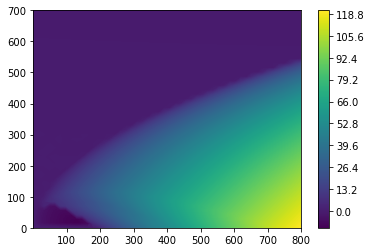

In [222]:
fig, ax = plt.subplots()
cs = ax.contourf(k_vect, a_vect, mu_a_t[:,:,0], levels = 800)
cbar = fig.colorbar(cs)

plt.show()

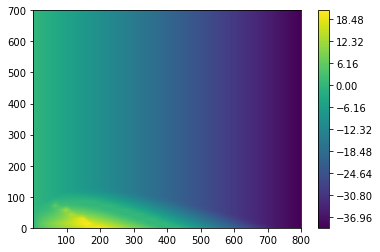

In [223]:
fig, ax = plt.subplots()
cs = ax.contourf(k_vect, a_vect, mu_k_t[:,:,0], levels = 800)
cbar = fig.colorbar(cs)

plt.show()

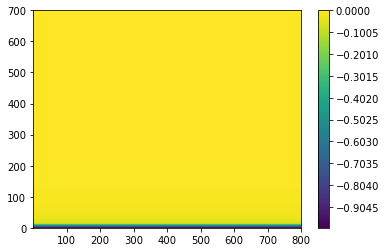

In [224]:
fig, ax = plt.subplots()
cs = ax.contourf(k_vect, a_vect, V_t[:,:,-1], levels = 800)
cbar = fig.colorbar(cs)

plt.show()

In [225]:
# Plot paths of policy and state variables
c_path = np.zeros(nT)
h_path = np.zeros(nT)
x_path = np.zeros(nT)
w_path = np.zeros(nT)
a_path = np.zeros(nT+1)
k_path = np.zeros(nT+1)

# Initial starting state
a_path[0] = a_vect[np.argmin(np.abs(a_vect - 40))] # Start at a_vect grid point closest to 40
k_path[0] = k_vect[1]

for t in range(0, nT):
    a = a_path[t]
    k = k_path[t]

    c_path[t] = C_policy_dict[t](a, k)
    h_path[t] = H_policy_dict[t](a, k)
    x_path[t] = X_policy_dict[t](a, k)

    w_path[t] = g(x_path[t])*k

    a_path[t+1] = a + dt*mu_a_dict[t](a, k)
    k_path[t+1] = k + dt*mu_k_dict[t](a, k)

l_path = 1 - h_path

In [226]:
K, A = np.meshgrid(k_vect, a_vect)

Text(0.5, 0, 'V')

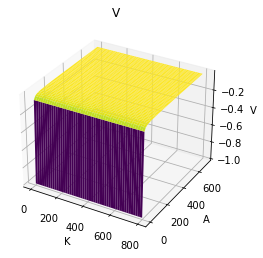

In [227]:
ax = plt.axes(projection='3d')
ax.plot_surface(K, A, V_t[:, :, -1], rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('V')
ax.set_xlabel('K')
ax.set_ylabel('A')
ax.set_zlabel('V')

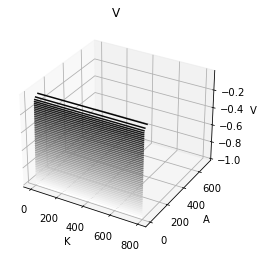

In [228]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(K, A, V_t[:, :, -1], 50, cmap='binary')
ax.set_title('V')
ax.set_xlabel('K')
ax.set_ylabel('A')
ax.set_zlabel('V');

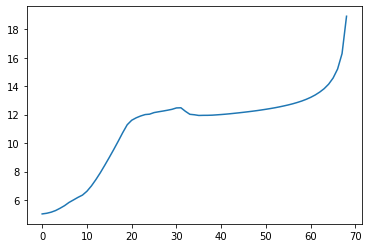

In [229]:
plt.plot(c_path[0:-1])

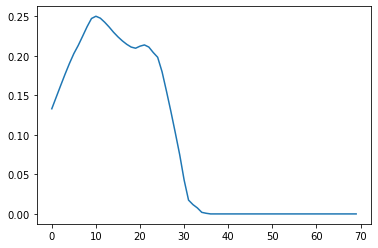

In [230]:
plt.plot(h_path)

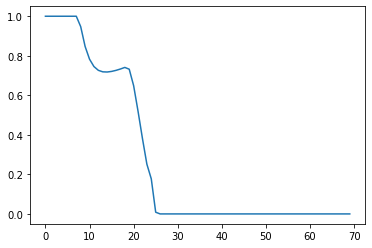

In [231]:
plt.plot(x_path)

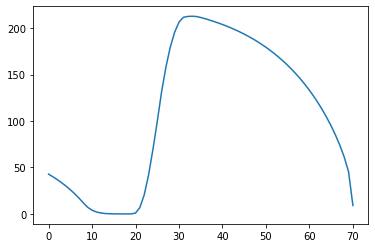

In [232]:
plt.plot(a_path)

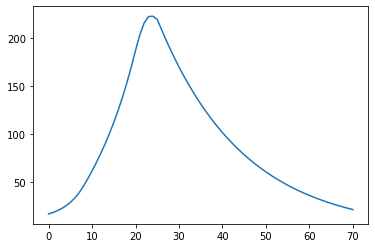

In [233]:
plt.plot(k_path)

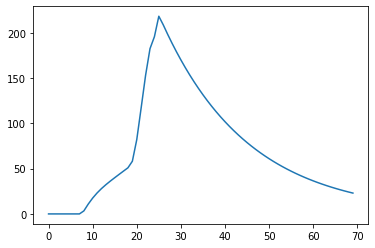

In [234]:
plt.plot(w_path)

In [235]:
phase_2 = np.argmax(x_path < 1)
phase_3 = np.argmax(x_path == 0)
phase_4 = np.argmax(h_path == 0)
phase_lines = [phase_2, phase_3, phase_4]

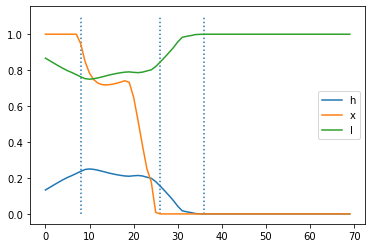

In [236]:
plt.plot(h_path, label = "h")
plt.plot(x_path, label = "x")
plt.plot(l_path, label = "l")
plt.vlines(phase_lines, 0, 1.1, linestyles = "dotted")

plt.legend()
plt.savefig('../output/fd_hjb_choice_path.pdf', bbox_inches='tight')
plt.show()

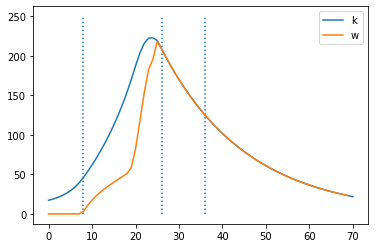

In [237]:
plt.plot(k_path, label = "k")
plt.plot(w_path, label = "w")
plt.vlines(phase_lines, 0, 250, linestyles = "dotted")

plt.legend()
plt.savefig('../output/fd_hjb_state_path.pdf', bbox_inches='tight')
plt.show()